# K-Medoids++, K-Means++, and Shape Clustering

Guilherme Franca <guifranca@gmail.com>, 08/22/2016

Abstract: We implement K-medoids algorithm and compare it to $K$-means. We use the same idea as $K$-means++ for initialization. We compare our own implementation with $K$-means implementation from *scikit-learn* library. We evaluate both algorithms in image clustering.

## A Bit of Theory

$K$-medoids algorithm is very similar to $K$-means with the exception that instead of getting a mean of the points inside the cluster, we pick the *medoid*. A medoid is a data point whose average dissimilarity to all objects in the cluster is minimal. In other words, it's the closest data point to the center of the data in that cluster.

Compared to $K$-means it is more robust to noise and to outliers.

The algorithm is described as follows. Consider a distance function $\mathcal{V}(x_i, x_j)$
between data points $X = \{x_i\}_{i=1}^N$. Let
$$
z_{nk} = \begin{cases}
1 & \mbox{if $x_n \in C_k$} \\
0 & \mbox{otherwise}
\end{cases}
$$
where $C_k$, $k=1,\dotsc,K$, represents the $k$th cluster. We want to minimize the cost function
$$
J = \dfrac{1}{2}\sum_{n=1}^N \sum_{k=1}^K z_{nk} \mathcal{V}(x_n, m_k)
$$
where $m_k$ is the $k$th medoid of cluster $k$. We do this as follows:
    
1. Given a data set $X$ compute the distance matrix $D \in \mathbb{R}^{N \times N}$ between data points.
2. Initialize medoids $\{m_1, \dotsc, m_K\}$.
3. $Z$-update: 
$$
z_{nk} = \begin{cases} 
1 & \mbox{ if $k = \mbox{argmin}_{j} \mathcal{V}(x_n, m_j)$ } \\ 
0 & \mbox{otherwise}
\end{cases}
$$

4. $M$-update:
$$
m_k = \mbox{argmin}_{x_l \in C_k}\left\{ \dfrac{1}{n_k} \sum_{x_i \in C_k} \mathcal{V}(x_l,x_i)\right\}
$$
5. Repeat 3 and 4 until convergence.

Notice that we just need to compute distance between data points, thus we can compute a distance matrix $D_{ij} = \mathcal{V}(x_i, x_j)$ and implement this algorithm just working with the indices of the data points.

Moreover, we can choose the initialization step 2 in the same way as $K$-means++. 

This implementation can be found on file **kmedoids.py**.
    

## Comparison $K$-Medoids and $K$-Means for Gaussian Clusters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import datasets
from sklearn import metrics
from sklearn.cluster import KMeans

import kmedoids
import kmeans
import clusval

golden = (1+np.sqrt(5))/2

In [2]:
# artificial data from normal distributions
mean = np.array([0,0])
cov = np.array([[4,0], [0,1]])
data1 = np.random.multivariate_normal(mean, cov, 200)
mean = np.array([3,5])
cov = np.array([[1,0.8], [0.8,2]])
data2 = np.random.multivariate_normal(mean, cov, 200)
mean = np.array([-2,3])
cov = np.array([[0.5,0], [0,0.5]])
data3 = np.random.multivariate_normal(mean, cov, 200)
data = np.concatenate((data1, data2, data3))
labels = np.concatenate(([0]*200, [1]*200, [2]*200))

In [3]:
# K-medoids
K=3
D = kmedoids.euclidean(data)
J, M = kmedoids.kmedoids(K, D)

In [4]:
# Our own implementation of K-means
K=3
JJ, MM = kmeans.kmeans_(K, data)

In [5]:
# Scikit-Learn K-means
K=3
km = KMeans(K)
r = km.fit(data)
JJJ = r.labels_

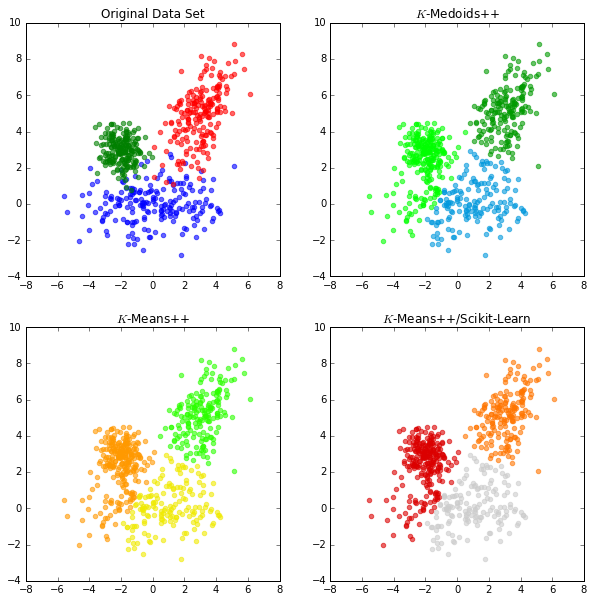

In [7]:
%matplotlib inline

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(221)
ax.scatter(data1[:,0], data1[:,1], color='b', alpha=.6)
ax.scatter(data2[:,0], data2[:,1], color='r', alpha=.6)
ax.scatter(data3[:,0], data3[:,1], color='g', alpha=.6)
ax.set_title('Original Data Set')

ax = fig.add_subplot(222)
cc = cm.spectral(np.linspace(0.3,0.6,K))
for k in range(K):
    idx = np.where(J==k)
    ax.scatter(data[:,0][idx], data[:,1][idx], color=cc[k], alpha=.6)
ax.set_title('$K$-Medoids++')
    
ax = fig.add_subplot(223)
cc = cm.spectral(np.linspace(0.61,0.8,K))
for k in range(K):
    idx = np.where(JJ==k)
    ax.scatter(data[:,0][idx], data[:,1][idx], color=cc[k], alpha=.6)
ax.set_title('$K$-Means++')

ax = fig.add_subplot(224)
cc = cm.spectral(np.linspace(0.81,1,K))
for k in range(K):
    idx = np.where(JJJ==k)
    ax.scatter(data[:,0][idx], data[:,1][idx], color=cc[k], alpha=.6)
ax.set_title('$K$-Means++/Scikit-Learn')

In [8]:
# mutual information (unnormalized)
print metrics.mutual_info_score(labels, J)
print metrics.mutual_info_score(labels, JJ)
print metrics.mutual_info_score(labels, JJJ)
print
# normalized NMI
print metrics.normalized_mutual_info_score(labels, J)
print metrics.normalized_mutual_info_score(labels, JJ)
print metrics.normalized_mutual_info_score(labels, JJ)
print
# adjusted MI, this is not so common
print metrics.adjusted_mutual_info_score(labels, J)
print metrics.adjusted_mutual_info_score(labels, JJ)
print metrics.adjusted_mutual_info_score(labels, JJJ)
print
# ARI (adjusted Rand Index)
print metrics.adjusted_rand_score(labels, J)
print metrics.adjusted_rand_score(labels, JJ)
print metrics.adjusted_rand_score(labels, JJJ)
print
# Misclassification Error
print clusval.misclassification_error(labels, J)
print clusval.misclassification_error(labels, JJ)
print clusval.misclassification_error(labels, JJJ)

0.755741154588
0.76434638159
0.76434638159

0.695034865566
0.702762407863
0.702762407863

0.6869509938
0.694807762602
0.694807762667

0.678049150712
0.683368069608
0.683368069608

0.126666666667
0.125
0.125


In this case both $K$-medoids and $K$-means seems to be clustering very closely.

In the next plots we choose a range of $N$, the number of data points. For each time we randomly generate data from normal distributions with the same parameters as before, then we run the algorithms 10 times and calculate the average score, and the maximum and the minimum as well to plot error bars. Notice that scikit-learn implementation probably runs $K$-means several times and pick the best answer. We are not doing that in our implementation so this is why we have a big variability, specially for low $N$.

In [9]:
nrange = range(10, 300, 5)
kmedoids_metric, kmeans_metric, kmeans_sklearn_metric = clusval.gauss_eval(kmedoids.euclidean, metrics.normalized_mutual_info_score, nrange, num_avg=10)

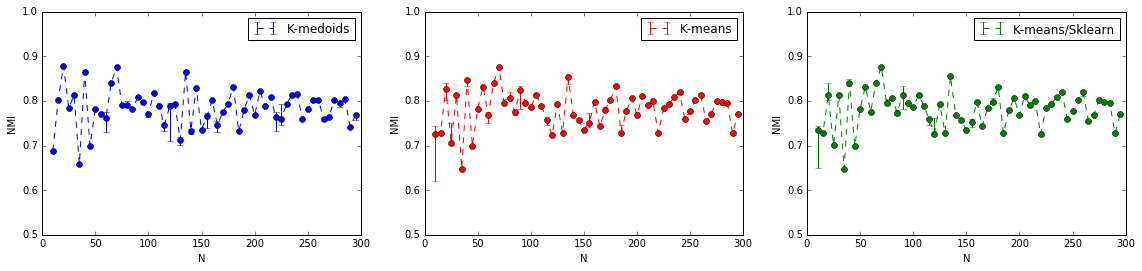

In [10]:
def errplot(ax, xs, data, label, color, ylabel, yrange=[0.5,1]):
    a = np.array(data)
    mean = a[:,0]
    lower = mean - a[:,1]
    upper = a[:,2] - mean
    error = [lower, upper]
    ax.errorbar(xs, mean, yerr=error, label=label, color=color, ls='dashed')
    ax.plot(xs, mean, 'o', color=color)
    ax.set_ylim(yrange)
    ax.set_xlabel('N')
    ax.set_ylabel(ylabel)
    ax.legend(loc=0)

fig = plt.figure(figsize=(4*golden*3,4))
ax = fig.add_subplot(131)
errplot(ax, nrange, kmedoids_metric, 'K-medoids', 'blue', 'NMI')
ax1 = fig.add_subplot(132, sharex=ax)
errplot(ax1, nrange, kmeans_metric, 'K-means', 'red', 'NMI')
ax2 = fig.add_subplot(133, sharex=ax)
errplot(ax2, nrange, kmeans_sklearn_metric, 'K-means/Sklearn', 'green', 'NMI')

In [11]:
nrange = range(10, 300, 5)
kmedoids_metric, kmeans_metric, kmeans_sklearn_metric = clusval.gauss_eval(kmedoids.euclidean, clusval.misclassification_error, nrange, num_avg=10)

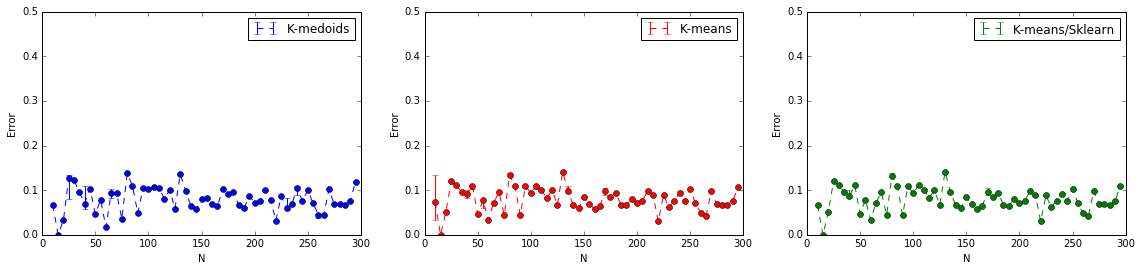

In [12]:
fig = plt.figure(figsize=(4*golden*3,4))
ax = fig.add_subplot(131)
errplot(ax, nrange, kmedoids_metric, 'K-medoids', 'blue', 'Error', yrange=[0,0.5])
ax1 = fig.add_subplot(132, sharex=ax)
errplot(ax1, nrange, kmeans_metric, 'K-means', 'red', 'Error', yrange=[0,0.5])
ax2 = fig.add_subplot(133, sharex=ax)
errplot(ax2, nrange, kmeans_sklearn_metric, 'K-means/Sklearn', 'green', 'Error', yrange=[0,0.5])

## Comparing $K$-Medoids and $K$-Means for Iris Dataset

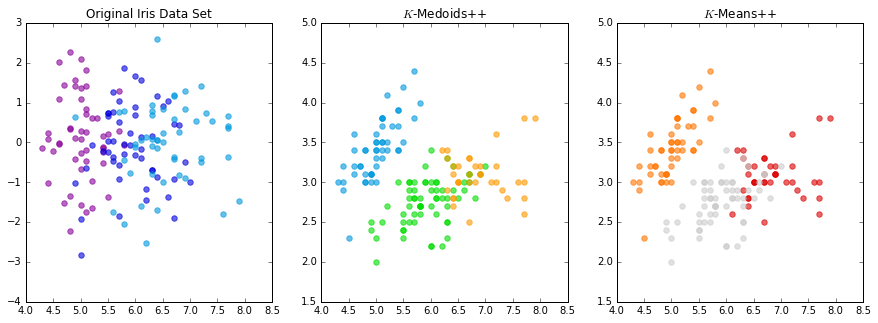

In [13]:
# using the iris data set

iris = datasets.load_iris()
iris_data = iris.data
iris_label = iris.target

K = 3
J, M = kmedoids.kmedoids(K, kmedoids.euclidean(iris_data))
JJ, MM = kmeans.kmeans(K, iris_data)

fig = plt.figure(figsize=(15,5))

s = 30 #marker size
ax = fig.add_subplot(131)
cc = cm.spectral(np.linspace(0.1, 0.3, K))
for k in range(K):
    idx = np.where(iris_label==k)
    ax.scatter(iris_data[:,0][idx], data1[:,1][idx], color=cc[k], alpha=.6, s=s)
ax.set_title('Original Iris Data Set')

ax = fig.add_subplot(132)
cc = cm.spectral(np.linspace(0.3,0.8,K))
for k in range(K):
    idx = np.where(J==k)
    ax.scatter(iris_data[:,0][idx], iris_data[:,1][idx], color=cc[k], alpha=.6, s=s)
ax.set_title('$K$-Medoids++')
    
ax = fig.add_subplot(133)
cc = cm.spectral(np.linspace(0.81,1,K))
for k in range(K):
    idx = np.where(JJ==k)
    ax.scatter(iris_data[:,0][idx], iris_data[:,1][idx], color=cc[k], alpha=.6, s=s)
ax.set_title('$K$-Means++')

In [14]:
labels = iris_label

# mutual information (unnormalized)
print metrics.mutual_info_score(labels, J)
print metrics.mutual_info_score(labels, JJ)
print
# normalized NMI
print metrics.normalized_mutual_info_score(labels, J)
print metrics.normalized_mutual_info_score(labels, JJ)
print
# adjusted MI, this is not so common
print metrics.adjusted_mutual_info_score(labels, J)
print metrics.adjusted_mutual_info_score(labels, JJ)
print
# ARI (adjusted Rand Index)
print metrics.adjusted_rand_score(labels, J)
print metrics.adjusted_rand_score(labels, JJ)
print
# Misclassification Error
print clusval.misclassification_error(labels, J)
print clusval.misclassification_error(labels, JJ)

0.864523826966
0.82559109761

0.798067420537
0.758205727819

0.784252780334
0.74837231318

0.74550386818
0.730238272283

0.1
0.106666666667


## Comparing $K$-Medoids and $K$-Means for MNIST Dataset

In [15]:
digits = datasets.load_digits()
images = digits.images
print images.shape

(1797, 8, 8)


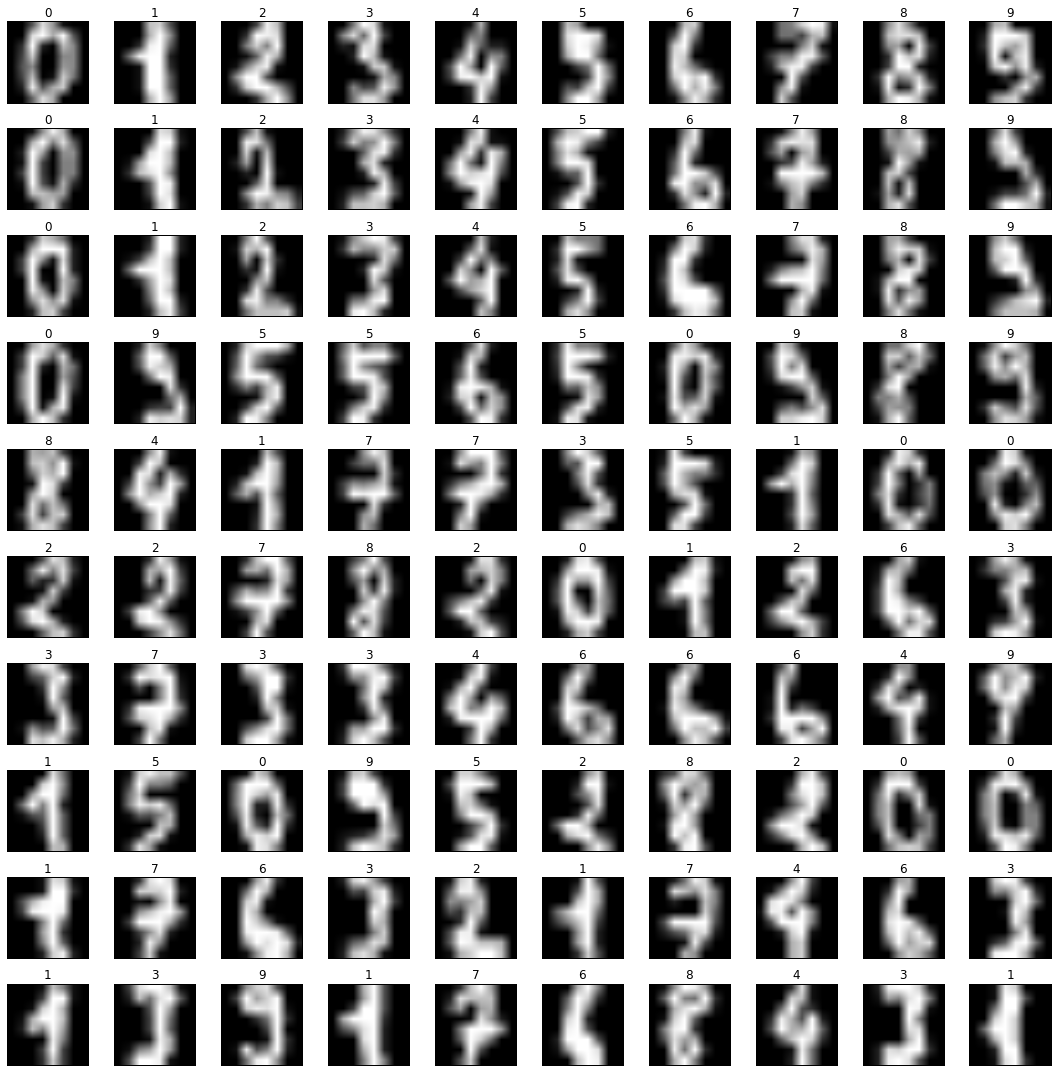

In [16]:
# showing a sample of the figures
fig = plt.figure(figsize=(15,15))
for i, img in enumerate(images[:100]):
    ax = fig.add_subplot(10, 10, i+1)
    ax.imshow(img, cmap=cm.gray)
    ax.set_title("%i" % digits.target[i])
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

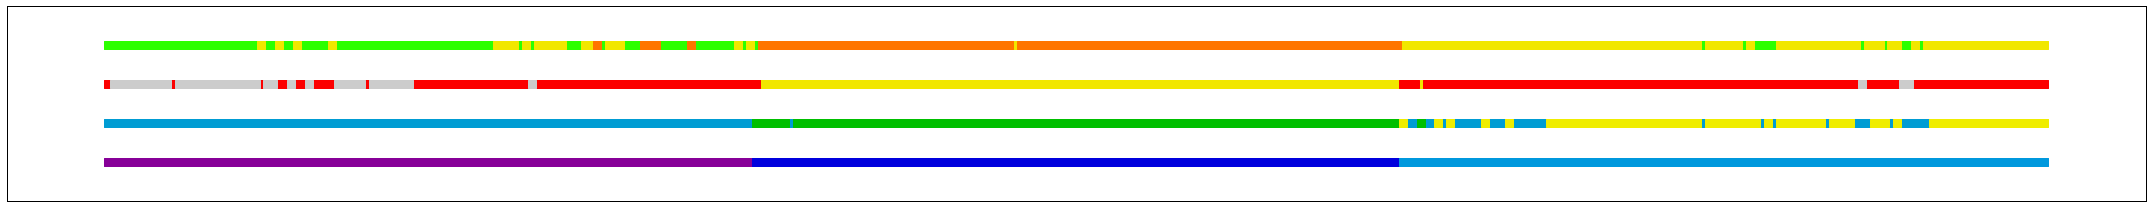

In [23]:
%matplotlib inline

# picking some digits
n = [110, 110, 110]
d = [1, 5, 8]
labels = np.concatenate([[i]*x for i, x in enumerate(n)])

data = np.concatenate([images[np.where(digits.target==i)][:m].reshape((m, 64)) 
                       for i, m in zip(d, n)])

# just to plot points and visualize data
coords = np.array([i for i in range(len(data))])

J, M = kmedoids.kmedoids(len(n), kmedoids.euclidean(data))
JJ, MM = kmeans.kmeans(len(n), data)
km = KMeans(len(n))
JJJ = km.fit(data).labels_

fig = plt.figure(figsize=(30,3))
ax = fig.add_subplot(111)
ax.set_xticks([])
ax.set_yticks([])
cc = cm.spectral(np.linspace(0.1, 0.3, len(n)))
s = 50
for k in range(len(n)):
    idx = np.where(labels==k)[0]
    ax.scatter(coords[idx], [0]*len(idx), color=cc[k], s=s, marker='s')

cc = cm.spectral(np.linspace(0.31, 0.7, len(n)))
for k in range(len(n)):
    idx = np.where(J==k)[0]
    ax.scatter(coords[idx], [1]*len(idx), color=cc[k], s=s, marker='s')

cc = cm.spectral(np.linspace(0.71, 1, len(n)))
for k in range(len(n)):
    idx = np.where(JJ==k)[0]
    ax.scatter(coords[idx], [2]*len(idx), color=cc[k], s=s, marker='s')

cc = cm.spectral(np.linspace(0.61, 0.81, len(n)))
for k in range(len(n)):
    idx = np.where(JJJ==k)[0]
    ax.scatter(coords[idx], [3]*len(idx), color=cc[k], s=s, marker='s')
    
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(-1, 4)
fig.tight_layout()


The above figure show each a colored dot for each digit category. The bottom dots are the true digits, the second line of dots are the digits clustered by $K$-medoids++, and the top 2 lines of dots using $K$-means++, from our implementation and scikit-learn, respectivelly.

In [24]:
# mutual information (unnormalized)
print metrics.mutual_info_score(labels, J)
print metrics.mutual_info_score(labels, JJ)
print metrics.mutual_info_score(labels, JJJ)
print
# normalized NMI
print metrics.normalized_mutual_info_score(labels, J)
print metrics.normalized_mutual_info_score(labels, JJ)
print metrics.normalized_mutual_info_score(labels, JJJ)
print
# adjusted MI, this is not so common
print metrics.adjusted_mutual_info_score(labels, J)
print metrics.adjusted_mutual_info_score(labels, JJ)
print metrics.adjusted_mutual_info_score(labels, JJJ)
print
# ARI (adjusted Rand Index)
print metrics.adjusted_rand_score(labels, J)
print metrics.adjusted_rand_score(labels, JJ)
print metrics.adjusted_rand_score(labels, JJJ)
print
# Misclassification Error
print clusval.misclassification_error(labels, J)
print clusval.misclassification_error(labels, JJ)
print clusval.misclassification_error(labels, JJJ)

0.8336840642
0.673838762306
0.73034486939

0.769598326738
0.652712572831
0.666172142115

0.757502304755
0.611183912659
0.662913493653

0.735752641899
0.565638860744
0.69499601147

0.10303030303
0.224242424242
0.118181818182


From the above indexes it seems that $K$-means is doing a better job than $K$-medoids.


## Evaluating $K$-Medoids++ and $K$-Means++ on MNIST

Now we evaluate the above clustering more systematically. We analyse several metric indices against $N$, the size of the data set. We also run the algorithm several times and take the average result.


In [25]:
numbers = [1, 5, 8]
nrange = range(10, 170, 5)
kmedoids_metric, kmeans_metric, kmeans_sklearn_metric = clusval.MNIST_eval(kmedoids.euclidean, metrics.normalized_mutual_info_score, numbers, nrange, num_avg=8)

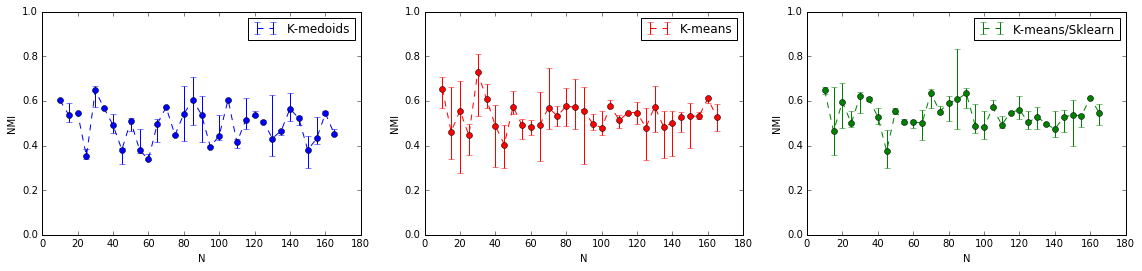

In [26]:
def errplot(ax, xs, data, label, color, ylabel, yrange=[0,1]):
    a = np.array(data)
    mean = a[:,0]
    lower = mean - a[:,1]
    upper = a[:,2] - mean
    error = [lower, upper]
    ax.errorbar(xs, mean, yerr=error, label=label, color=color, ls='dashed')
    ax.plot(xs, mean, 'o', color=color)
    ax.set_ylim(yrange)
    ax.set_xlabel('N')
    ax.set_ylabel(ylabel)
    ax.legend(loc=0)

fig = plt.figure(figsize=(4*golden*3,4))
ax = fig.add_subplot(131)
errplot(ax, nrange, kmedoids_metric, 'K-medoids', 'blue', 'NMI')
ax1 = fig.add_subplot(132, sharex=ax)
errplot(ax1, nrange, kmeans_metric, 'K-means', 'red', 'NMI')
ax2 = fig.add_subplot(133, sharex=ax)
errplot(ax2, nrange, kmeans_sklearn_metric, 'K-means/Sklearn', 'green', 'NMI')

In [27]:
numbers = [1, 5, 8]
nrange = range(10, 170, 5)
kmedoids_metric, kmeans_metric, kmeans_sklearn_metric = clusval.MNIST_eval(kmedoids.euclidean, clusval.misclassification_error, numbers, nrange, num_avg=10)

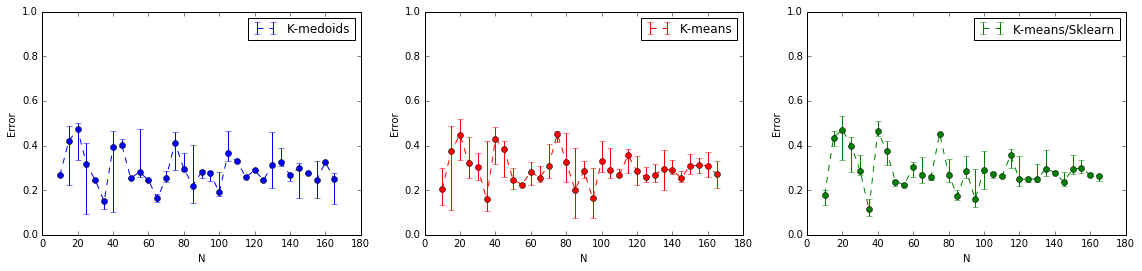

In [28]:
fig = plt.figure(figsize=(4*golden*3,4))
ax = fig.add_subplot(131)
errplot(ax, nrange, kmedoids_metric, 'K-medoids', 'blue', 'Error')
ax1 = fig.add_subplot(132, sharex=ax)
errplot(ax1, nrange, kmeans_metric, 'K-means', 'red', 'Error')
ax2 = fig.add_subplot(133, sharex=ax)
errplot(ax2, nrange, kmeans_sklearn_metric, 'K-means/Sklearn', 'green', 'Error')